In [68]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import roc_curve, auc, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [69]:
# 1. read the data and setup
n_number = 10062866
random.seed(n_number)
np.random.seed(n_number)
torch.manual_seed(n_number)
df = pd.read_csv('musicData.csv', na_values=['?', -1])
print(f"Original dataset shape: {df.shape}")
print(f"Number of missing values:\n{df.isna().sum()}")

#drop the insignificant columns
columns_to_drop = ['instance_id', 'artist_name', 'track_name', 'obtained_date']
df.drop(columns=columns_to_drop, inplace=True)
df_clean = df.dropna()
print(f"Dataset shape after dropping missing values: {df_clean.shape}")
print(df_clean)

Original dataset shape: (50005, 18)
Number of missing values:
instance_id            5
artist_name            5
track_name             5
popularity             5
acousticness           5
danceability           5
duration_ms         4944
energy                 5
instrumentalness       5
key                    5
liveness               5
loudness               5
mode                   5
speechiness            5
tempo               4985
obtained_date          5
valence                5
music_genre            5
dtype: int64
Dataset shape after dropping missing values: (40560, 14)
       popularity  acousticness  danceability  duration_ms  energy  \
1            31.0       0.01270         0.622     218293.0   0.890   
2            28.0       0.00306         0.620     215613.0   0.755   
3            34.0       0.02540         0.774     166875.0   0.700   
4            32.0       0.00465         0.638     222369.0   0.587   
6            46.0       0.02890         0.572     214408.0   0.803  

In [70]:
# 2.encode key, mode, and genre
key_mapping = {
        'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5,
        'F#': 6, 'G': 7, 'G#': 8, 'A': 9, 'A#': 10, 'B': 11
    }
df_clean['key'] = df_clean['key'].map(key_mapping)
mode_mapping = {'Minor': 0, 'Major': 1}
df_clean['mode'] = df_clean['mode'].map(mode_mapping)
genres = df_clean['music_genre'].unique()
genre_mapping = {genre: i for i, genre in enumerate(sorted(genres))}
df_clean['genre_numeric'] = df_clean['music_genre'].map(genre_mapping)
print(genres)
print(f"Genre mapping: {genre_mapping}")
print(df_clean)

['Electronic' 'Anime' 'Jazz' 'Alternative' 'Country' 'Rap' 'Blues' 'Rock'
 'Classical' 'Hip-Hop']
Genre mapping: {'Alternative': 0, 'Anime': 1, 'Blues': 2, 'Classical': 3, 'Country': 4, 'Electronic': 5, 'Hip-Hop': 6, 'Jazz': 7, 'Rap': 8, 'Rock': 9}
       popularity  acousticness  danceability  duration_ms  energy  \
1            31.0       0.01270         0.622     218293.0   0.890   
2            28.0       0.00306         0.620     215613.0   0.755   
3            34.0       0.02540         0.774     166875.0   0.700   
4            32.0       0.00465         0.638     222369.0   0.587   
6            46.0       0.02890         0.572     214408.0   0.803   
...           ...           ...           ...          ...     ...   
49999        56.0       0.13300         0.849     237667.0   0.660   
50001        72.0       0.15700         0.709     251860.0   0.362   
50002        51.0       0.00597         0.693     189483.0   0.763   
50003        65.0       0.08310         0.782     2

In [71]:
# 3. Train/Test split
# Select 500 samples from each genre for the test set
test_indices = []
train_indices = []
for genre in genres:
    genre_indices = df_clean[df_clean['music_genre'] == genre].index.tolist()
    
    # Randomly select 500 samples for testing
    genre_test_indices = np.random.choice(genre_indices, 500, replace=False)
    genre_train_indices = list(set(genre_indices) - set(genre_test_indices))
    
    test_indices.extend(genre_test_indices)
    train_indices.extend(genre_train_indices)

# Create train and test sets
df_train = df_clean.loc[train_indices].reset_index(drop=True)
df_test = df_clean.loc[test_indices].reset_index(drop=True)
print(f"Train set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")
print(f"Genre distribution in test set:\n{df_test['music_genre'].value_counts()}")

Train set shape: (35560, 15)
Test set shape: (5000, 15)
Genre distribution in test set:
music_genre
Electronic     500
Anime          500
Jazz           500
Alternative    500
Country        500
Rap            500
Blues          500
Rock           500
Classical      500
Hip-Hop        500
Name: count, dtype: int64


In [72]:
# 4. Feature scaling 
X_train = df_train.drop(['music_genre', 'genre_numeric'], axis=1)
y_train = df_train['genre_numeric']
X_test = df_test.drop(['music_genre', 'genre_numeric'], axis=1)
y_test = df_test['genre_numeric']
categorical_cols = ['mode']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

Text(0.5, 1.0, 't-SNE visualization of genres')

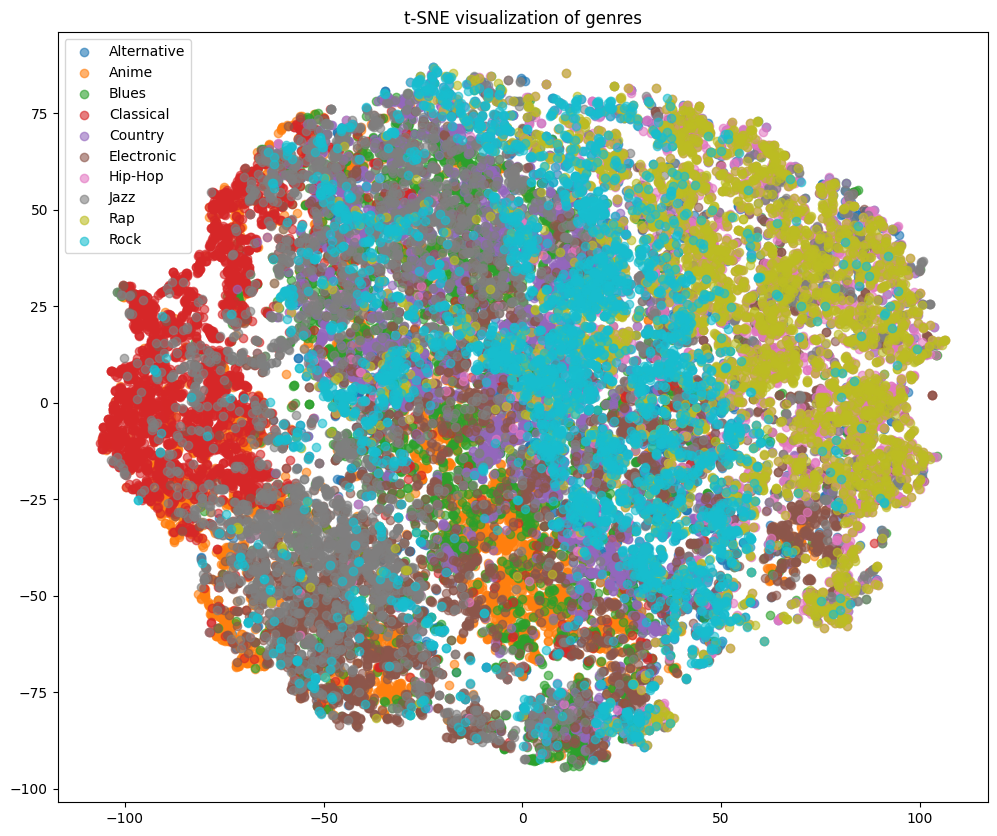

In [73]:
# 5. Dimension reduction with t-SNE
tsne = TSNE(n_components=2, random_state=n_number, perplexity=30)
tsne_results = tsne.fit_transform(X_train)
plt.figure(figsize=(12, 10))
for genre, label in genre_mapping.items():
    indices = df_train['music_genre'] == genre
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=genre, alpha=0.6)
plt.legend()
plt.title('t-SNE visualization of genres')

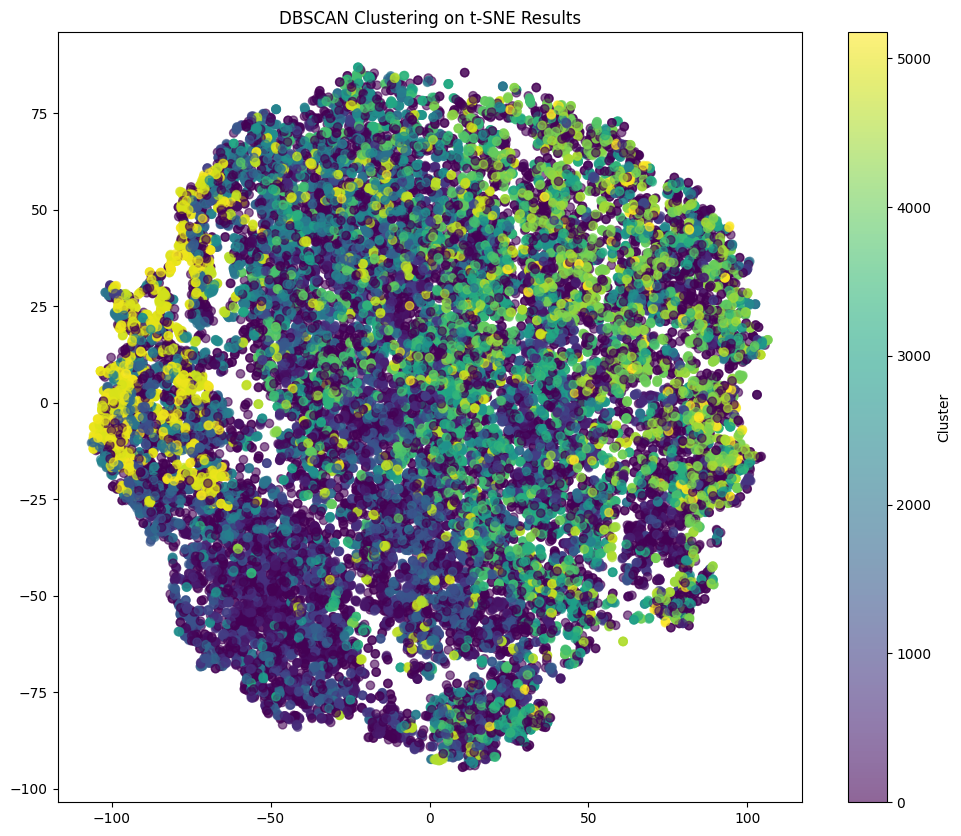

In [74]:
# Clustering using DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=3)
clusters = dbscan.fit_predict(tsne_results)

# Visualize clusters
plt.figure(figsize=(12, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('DBSCAN Clustering on t-SNE Results')
plt.colorbar(label='Cluster')

In [75]:
# 7. Neural Network Model for Classification
# Create PyTorch Dataset
class MusicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.LongTensor(y.values)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and dataloaders
train_dataset = MusicDataset(X_train, y_train)
test_dataset = MusicDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Training the neural network...
Epoch 10/100, Loss: 1.3143
Epoch 20/100, Loss: 1.2620
Epoch 30/100, Loss: 1.2360
Epoch 40/100, Loss: 1.2174
Epoch 50/100, Loss: 1.2022
Epoch 60/100, Loss: 1.1875
Epoch 70/100, Loss: 1.1822
Epoch 80/100, Loss: 1.1739
Epoch 90/100, Loss: 1.1670
Epoch 100/100, Loss: 1.1606


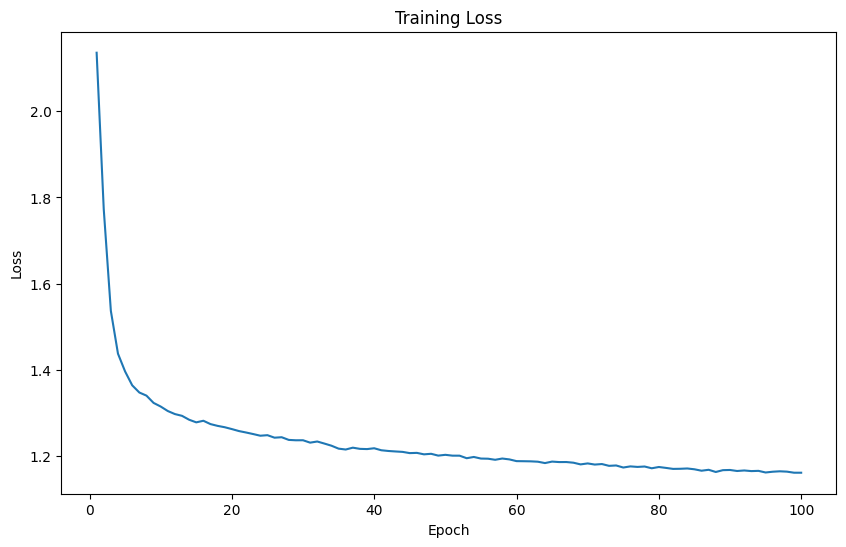

In [77]:
class MusicGenreClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MusicGenreClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Initialize the model
input_size = X_train.shape[1]
num_classes = len(genre_mapping)
model = MusicGenreClassifier(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
lambda_l2 = 1e-4
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

# Train the model
num_epochs = 100
train_losses = []

print("Training the neural network...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

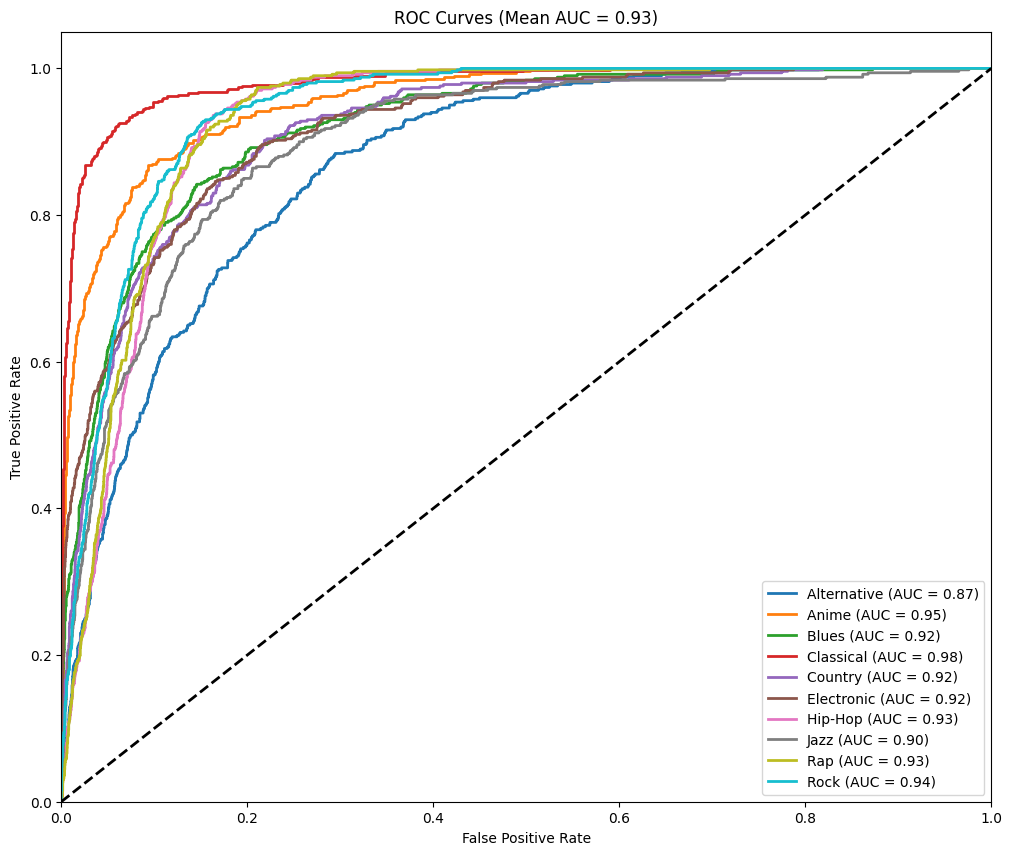

In [79]:
# Evaluate the model
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.append(probabilities)
        all_labels.append(labels)

all_probs = torch.cat(all_probs, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# One-hot encode the labels for ROC curve calculation
lb = LabelBinarizer()
lb.fit(range(num_classes))
y_test_bin = lb.transform(all_labels)

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 10))
for i in range(num_classes):
    genre_name = list(genre_mapping.keys())[list(genre_mapping.values()).index(i)]
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], lw=2, 
             label=f'{genre_name} (AUC = {roc_auc[i]:.2f})')

# Calculate mean AUC across all classes
mean_auc = np.mean(list(roc_auc.values()))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves (Mean AUC = {mean_auc:.2f})')
plt.legend(loc="lower right")

In [85]:
print(f"Mean AUC across all genres: {mean_auc:.4f}")

# Generate a more detailed report
print("\nDetailed AUC scores by genre:")
for i in range(num_classes):
    genre_name = list(genre_mapping.keys())[list(genre_mapping.values()).index(i)]
    print(f"{genre_name}: {roc_auc[i]:.4f}")

# Feature importance analysis (based on correlation with each genre)
print("\nAnalyzing feature importance...")
feature_importance = {}
for genre in genres:
    genre_idx = genre_mapping[genre]
    genre_binary = (df_train['genre_numeric'] == genre_idx).astype(int)
    
    # Calculate correlation for each feature with this genre
    correlations = {}
    for feature in X_train.columns:
        corr = np.corrcoef(X_train[feature], genre_binary)[0, 1]
        correlations[feature] = abs(corr)  # Using absolute correlation
    
    # Sort features by correlation strength
    sorted_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    feature_importance[genre] = sorted_features[:3]  # Top 3 features

print("\nTop 3 important features for each genre:")
for genre, features in feature_importance.items():
    print(f"{genre}: {[f[0] for f in features]}")


Mean AUC across all genres: 0.9259

Detailed AUC scores by genre:
Alternative: 0.8705
Anime: 0.9550
Blues: 0.9212
Classical: 0.9798
Country: 0.9159
Electronic: 0.9190
Hip-Hop: 0.9280
Jazz: 0.8985
Rap: 0.9305
Rock: 0.9409

Analyzing feature importance...

Top 3 important features for each genre:
Electronic: ['acousticness', 'instrumentalness', 'energy']
Anime: ['popularity', 'danceability', 'speechiness']
Jazz: ['acousticness', 'instrumentalness', 'energy']
Alternative: ['loudness', 'energy', 'acousticness']
Country: ['instrumentalness', 'mode', 'speechiness']
Rap: ['popularity', 'speechiness', 'danceability']
Blues: ['popularity', 'valence', 'speechiness']
Rock: ['popularity', 'speechiness', 'instrumentalness']
Classical: ['loudness', 'acousticness', 'energy']
Hip-Hop: ['speechiness', 'popularity', 'danceability']
